In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from IPython.display import display, HTML

path = os.getcwd()
file_folder = os.path.join(path,'it_features')
years = [2017,2018,2019,2020]
list_data= []
df = pd.DataFrame()
for year in years:
    number_of_weeks = 0
    for csv_file in os.listdir(file_folder):
        if str(year) in csv_file[15:]:
            short_name = csv_file[15:]
            #print(short_name)
            csv_path = os.path.join(file_folder,csv_file)
            df_temp = pd.read_csv(csv_path)
            year = short_name[0:4]
            month = short_name[5:7]
            day =short_name[8:10]
            date = year + '-' + month + '-' + day
            #print(date)
            
            df_temp['date'] = date
            df_temp.date = pd.to_datetime(df_temp.date)
            df_temp.set_index(df_temp.date, inplace=True)
            df_temp.drop(columns=['date'], inplace=True)
            
            df = pd.concat([df, df_temp])
#print(list_data)

In [2]:
df.sort_index(inplace = True)

In [3]:
df.describe()

,Unnamed: 0,Unnamed: 0.1,index,Position,Streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
count,37400.000000,37400.000000,37400.000000,37400.000000,3.740000e+04,37400.000000,37400.000000,37400.00000,37400.000000,37400.000000,37400.000000,37400.000000,37400.000000,37400.000000,37400.000000,37400.000000,37400.000000,37400.000000
mean,99.500000,99.500000,100.500000,100.500000,4.602958e+05,0.688842,0.677593,5.24139,-6.025736,0.549893,0.125659,0.201420,0.003916,0.165624,0.497279,119.560290,3.979091,200521.146070
std,57.735077,57.735077,57.735077,57.735077,4.459066e+05,0.121516,0.136627,3.69074,1.926925,0.497511,0.105679,0.197855,0.043100,0.126501,0.208633,27.401078,0.211797,34946.322285
min,0.000000,0.000000,1.000000,1.000000,5.154300e+04,0.168000,0.027900,0.00000,-34.475000,0.000000,0.023200,0.000176,0.000000,0.019600,0.034300,53.808000,1.000000,35240.000000
25%,49.750000,49.750000,50.750000,50.750000,2.242008e+05,0.617000,0.587000,1.00000,-7.049000,0.000000,0.048700,0.052200,0.000000,0.093100,0.339000,98.098000,4.000000,178120.000000
50%,99.500000,99.500000,100.500000,100.500000,3.365395e+05,0.703000,0.689000,6.00000,-5.773000,1.000000,0.080200,0.137000,0.000000,0.118000,0.497000,119.939000,4.000000,200976.000000
75%,149.250000,149.250000,150.250000,150.250000,5.272985e+05,0.774000,0.778000,8.00000,-4.792000,1.000000,0.178000,0.283000,0.000003,0.188000,0.657000,135.952000,4.000000,220293.000000
max,199.000000,199.000000,200.000000,200.000000,8.223614e+06,0.971000,0.982000,11.00000,-0.928000,1.000000,0.966000,0.994000,0.918000,0.921000,0.968000,212.117000,5.000000,526387.000000


In [4]:
df_resampled = df.resample('W').mean()

In [5]:
df_relevant = df_resampled.drop(columns=['Unnamed: 0','Unnamed: 0.1','index','Position','duration_ms'])

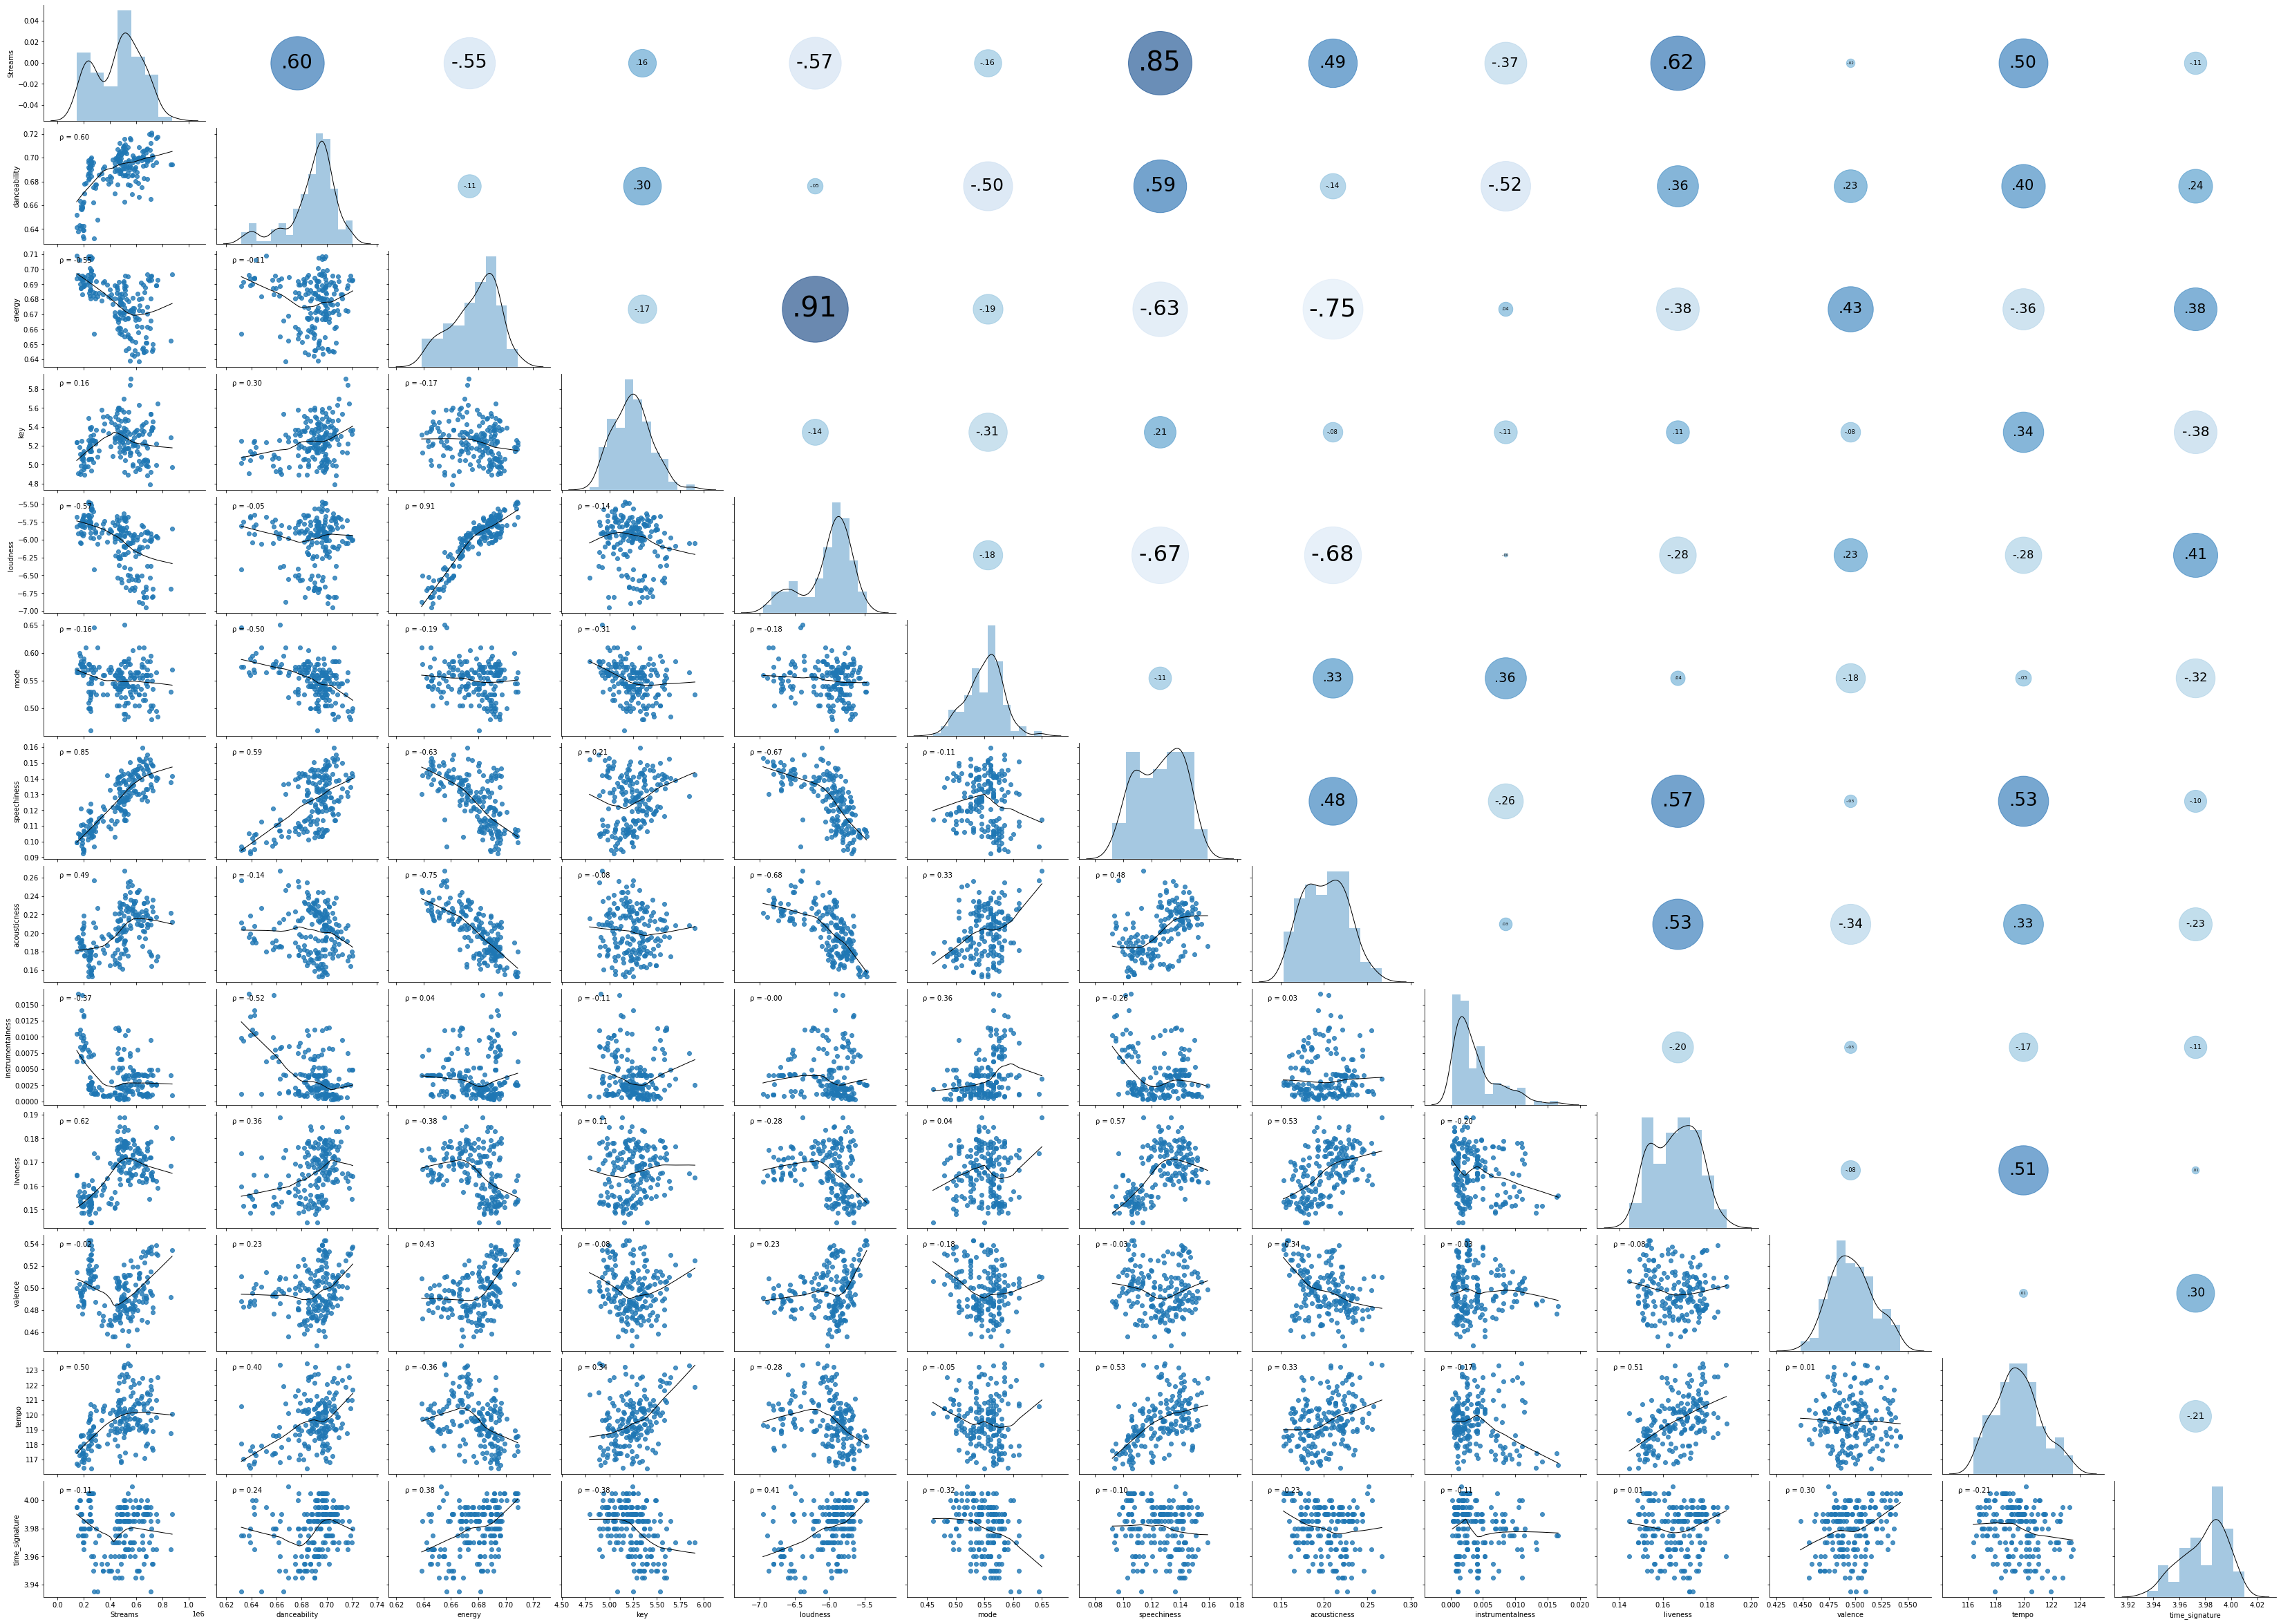

In [7]:
from scipy.stats import pearsonr

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="Blues",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    
    
# g = sns.pairplot(stocks,palette=["Blues_d"])
g = sns.PairGrid(df_relevant, aspect=1.4, diag_sharey=False)
g.map_lower(corrfunc)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'Black','linewidth':1})
g.map_diag(sns.distplot, kde_kws={'color': 'Black','linewidth':1})
g.map_upper(corrdot)
plt.show()

As it can be seen, the only relevant correlations are: 
- The negative correlation between `energy` and `acousticness` 
- The correlation between `energy` and `loudness`

We suppose that the TOP 50 can show a larger variance with respect to the TOP 200, since the latter will be influenced by songs that remain in the chart for longer periods. Let's check the trends from january to the end of the lockdown in Italy, considering the top50.

In [143]:
top50 = df[df['Position']<=50]
top50_resampled = top50.resample('W').mean()

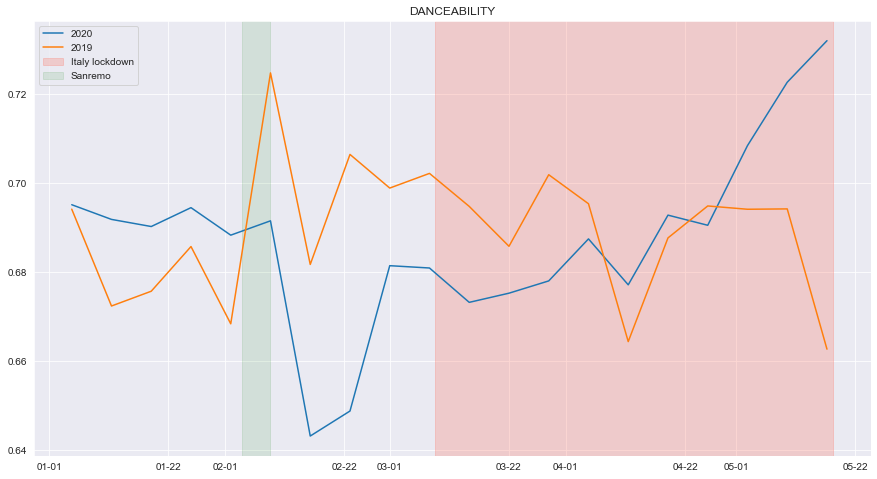

In [146]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(top50_resampled['2020-01':'2020-05-18'].index,  top50_resampled['2020-01':'2020-05-18'].danceability, label='2020')
ax.plot(top50_resampled['2020-01':'2020-05-20'].index,  top50_resampled['2019-01':'2019-05-20'].danceability, label='2019')
ax.axvspan(*mdates.datestr2num(['2020-03-09', '2020-05-18']), color='salmon', alpha=0.3, label="Italy lockdown")
ax.axvspan(*mdates.datestr2num(['2020-02-04', '2020-02-09']), color='green', alpha=0.1, label="Sanremo")
ax.legend(loc="upper left")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_title("DANCEABILITY")
plt.show()

We can see that `danceability` follows more or less the same trend as in 2019, with a drop right after the end of <b>Sanremo</b>, but with the difference that it starts to significantly grow from the beginning of May, and this <i> might </i> be due to the lockdown measures starting to be removed.

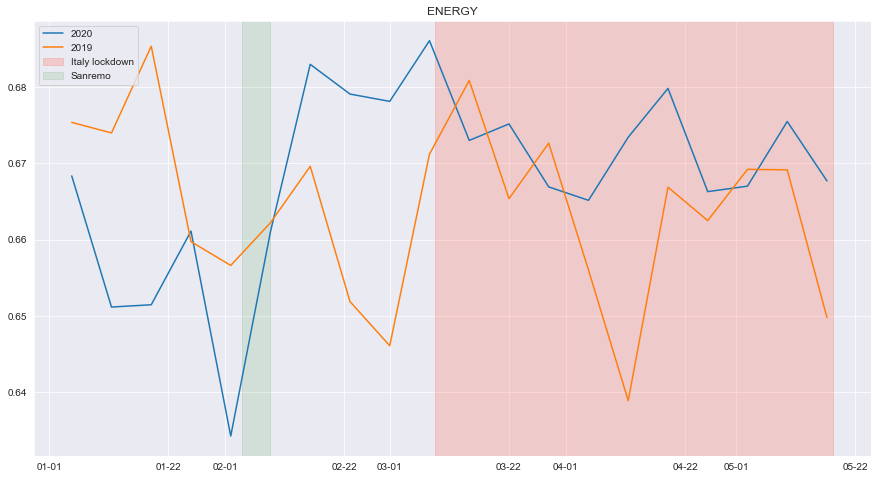

In [149]:
top50 = df[df['Position']<=50]
top50_resampled = top50.resample('W').mean()

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(top50_resampled['2020-01':'2020-05-18'].index,  top50_resampled['2020-01':'2020-05-18'].energy, label='2020')
ax.plot(top50_resampled['2020-01':'2020-05-20'].index,  top50_resampled['2019-01':'2019-05-20'].energy, label='2019')
ax.axvspan(*mdates.datestr2num(['2020-03-09', '2020-05-18']), color='salmon', alpha=0.3, label="Italy lockdown")
ax.axvspan(*mdates.datestr2num(['2020-02-04', '2020-02-09']), color='green', alpha=0.1, label="Sanremo")
ax.legend(loc="upper left")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_title("ENERGY")
plt.show()

Also for `energy` we have a trend that's similar to that of 2019, especially during the lockdown period, but with a more significant increase corresponding with <b> Sanremo </b>. This might be due to the song partecipating to the festival being more <i>energic</i>. 

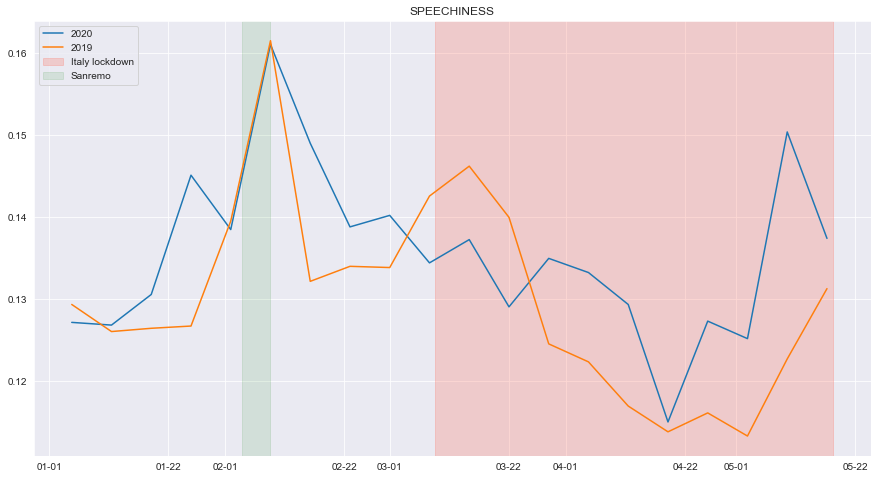

In [150]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(top50_resampled['2020-01':'2020-05-18'].index,  top50_resampled['2020-01':'2020-05-18'].speechiness, label='2020')
ax.plot(top50_resampled['2020-01':'2020-05-20'].index,  top50_resampled['2019-01':'2019-05-20'].speechiness, label='2019')
ax.axvspan(*mdates.datestr2num(['2020-03-09', '2020-05-18']), color='salmon', alpha=0.3, label="Italy lockdown")
ax.axvspan(*mdates.datestr2num(['2020-02-04', '2020-02-09']), color='green', alpha=0.1, label="Sanremo")
ax.legend(loc="upper left")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_title("SPEECHINESS")
plt.show()

For what concerns `speechiness` the pattern - except some spikes that might depend on the different artists releasing each year - is very consistent between the two years. 

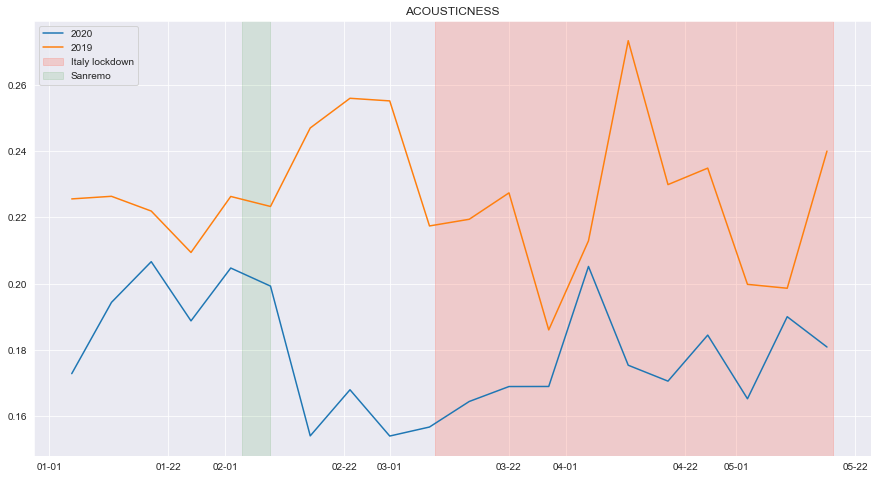

In [151]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(top50_resampled['2020-01':'2020-05-18'].index,  top50_resampled['2020-01':'2020-05-18'].acousticness, label='2020')
ax.plot(top50_resampled['2020-01':'2020-05-20'].index,  top50_resampled['2019-01':'2019-05-20'].acousticness, label='2019')
ax.axvspan(*mdates.datestr2num(['2020-03-09', '2020-05-18']), color='salmon', alpha=0.3, label="Italy lockdown")
ax.axvspan(*mdates.datestr2num(['2020-02-04', '2020-02-09']), color='green', alpha=0.1, label="Sanremo")
ax.legend(loc="upper left")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_title("ACOUSTICNESS")
plt.show()

The `acousticness` is coherent with what shown in the `energy`, showing a less acoustic - therefore more energic - top 50 in 2020 with respect to 2019. This trend starts well before the lockdown and the COVID-19 spread in Italy.

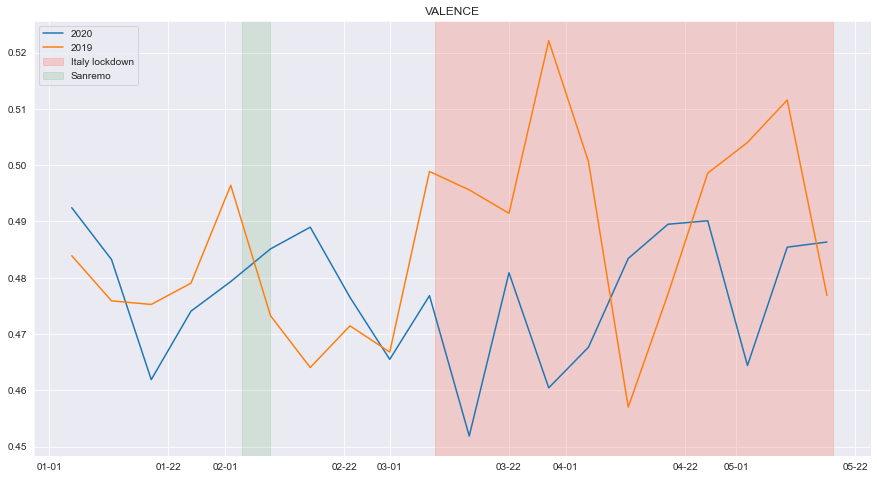

In [152]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(top50_resampled['2020-01':'2020-05-18'].index,  top50_resampled['2020-01':'2020-05-18'].valence, label='2020')
ax.plot(top50_resampled['2020-01':'2020-05-20'].index,  top50_resampled['2019-01':'2019-05-20'].valence, label='2019')
ax.axvspan(*mdates.datestr2num(['2020-03-09', '2020-05-18']), color='salmon', alpha=0.3, label="Italy lockdown")
ax.axvspan(*mdates.datestr2num(['2020-02-04', '2020-02-09']), color='green', alpha=0.1, label="Sanremo")
ax.legend(loc="upper left")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_title("VALENCE")
plt.show()

The `valence` in 2020 stays more or less the same as 2019 until the beginning of lockdown, when the valence increases significantly in 2019 differently from what happens in 2020.

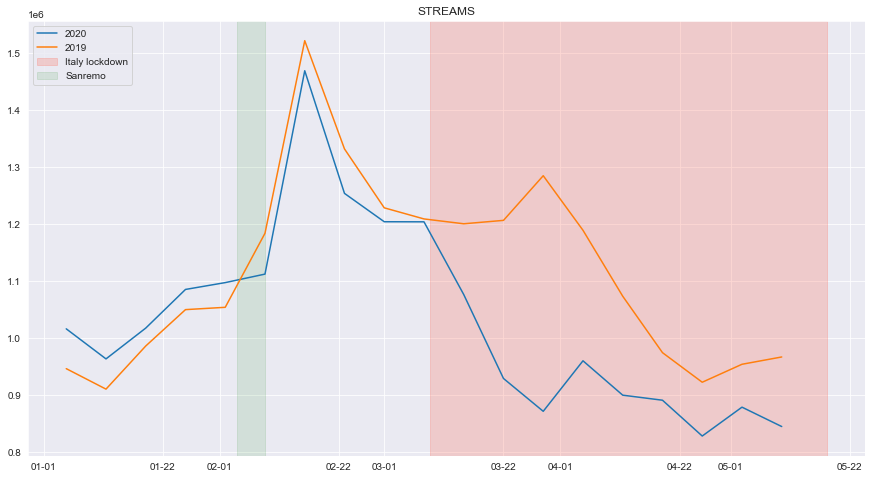

In [140]:
top50 = df[df['Position']<=50]
top50_resampled = top50.resample('W').mean()

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(top50_resampled['2020-01':'2020-05-18'].index,  top50_resampled['2020-01':'2020-05-18'].Streams, label='2020')
ax.plot(top50_resampled['2020-01':'2020-05-15'].index,  top50_resampled['2019-01':'2019-05-15'].Streams, label='2019')
ax.axvspan(*mdates.datestr2num(['2020-03-09', '2020-05-18']), color='salmon', alpha=0.3, label="Italy lockdown")
ax.axvspan(*mdates.datestr2num(['2020-02-04', '2020-02-09']), color='green', alpha=0.1, label="Sanremo")
ax.legend(loc="upper left")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_title("STREAMS")
plt.show()

We have a significant drop in `streams` in 2020, coinciding with the beginning of the lockdown. 

[Text(0.5, 0, 'week')]

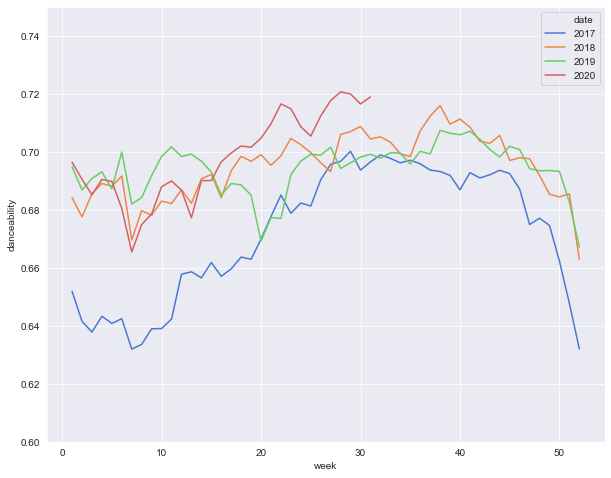

In [153]:
plt.figure(figsize = (10,8))
plt.ylim(0.6,0.75)
#sns.set_style("white")
sns.set_style("darkgrid")
ax = sns.lineplot(x=df_resampled.index.week, y='danceability', 
                  hue=df_resampled.index.year, data=df_resampled, ci=None, palette='muted')
ax.set(xlabel='week')

[Text(0.5, 1.0, 'ENERGY')]

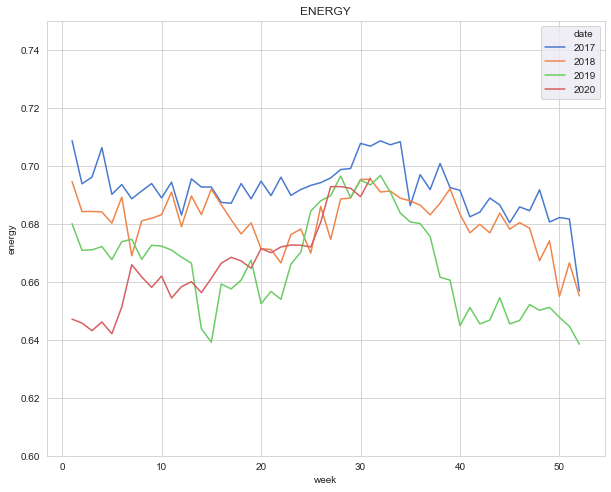

In [40]:
plt.figure(figsize = (10,8))
plt.ylim(0.6,0.75)
sns.set_style("white")
sns.set_style("darkgrid")
ax = sns.lineplot(x=df_resampled.index.week, y='energy', 
                  hue=df_resampled.index.year, data=df_resampled, ci='sd', palette='muted')
ax.set(xlabel='week')
ax.set(title="ENERGY")

[Text(0.5, 1.0, 'VALENCE')]

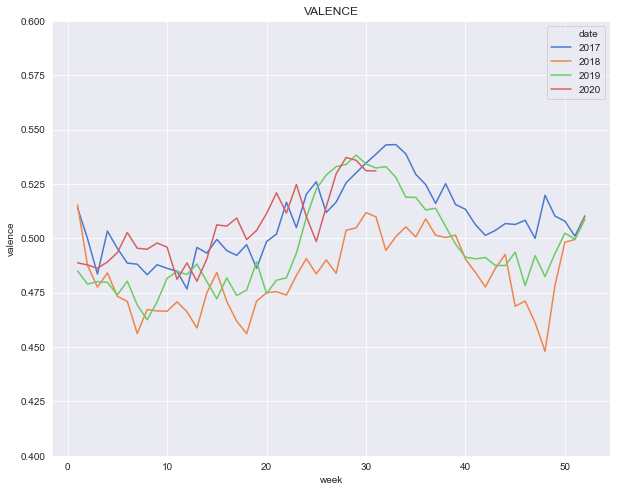

In [44]:
plt.figure(figsize = (10,8))
plt.ylim(0.4,0.6)
sns.set_style("white")
sns.set_style("darkgrid")
ax = sns.lineplot(x=df_resampled.index.week, y='valence', 
                  hue=df_resampled.index.year, data=df_resampled, ci='sd', palette='muted')
ax.set(xlabel='week')
ax.set(title="VALENCE")

[Text(0.5, 1.0, 'ACOUSTICNESS')]

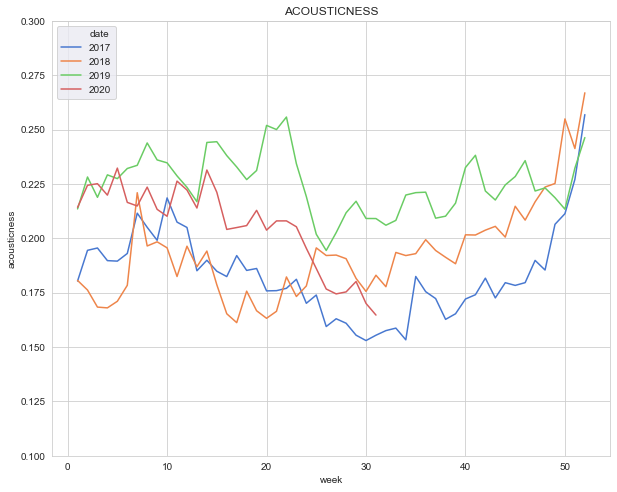

In [48]:
plt.figure(figsize = (10,8))
plt.ylim(0.1,0.3)
#sns.set_style("white")
sns.set_style("darkgrid")
ax = sns.lineplot(x=df_resampled.index.week, y='acousticness', 
                  hue=df_resampled.index.year, data=df_resampled, ci='sd', palette='muted')
ax.set(xlabel='week')
ax.set(title="ACOUSTICNESS")

Text(0.5, 1.0, 'SPEECHINESS')

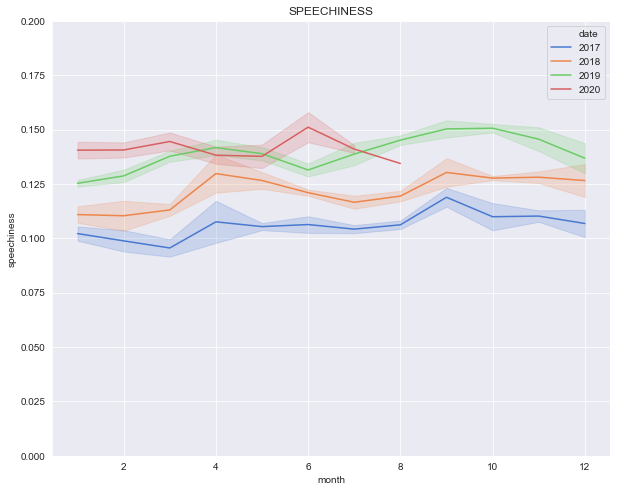

In [54]:
plt.figure(figsize = (10,8))
plt.ylim(0,0.2)
#sns.set_style("white")
sns.set_style("darkgrid")
ax = sns.lineplot(x=df_resampled.index.month, y='speechiness', 
                  hue=df_resampled.index.year, data=df_resampled, ci='sd', palette='muted')
ax.set(xlabel='month')
ax.set_title('SPEECHINESS')

[Text(0.5, 0, 'week')]

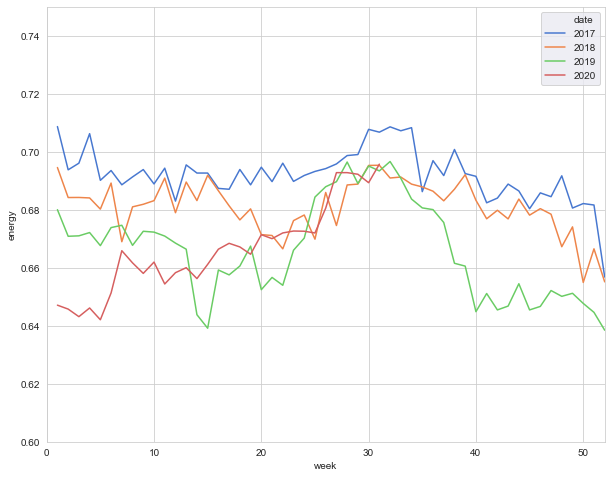

In [61]:
plt.figure(figsize = (10,8))
plt.ylim(0.6,0.75)
plt.xlim(0,52)
sns.set_style("darkgrid")
ax = sns.lineplot(x=df_resampled.index.week, y='energy', hue=df_resampled.index.year, data=df_resampled, ci='sd', palette='muted')
ax.set(xlabel='week')